In [27]:
import pandas as pd

df = pd.read_csv('../data/processed/atp_matches_2000-2024.csv')

In [28]:
import pandas as pd

def elo_expected(rating_a: float, rating_b: float) -> float:
    """Expected score for player A vs B."""
    return 1.0 / (1.0 + 10.0 ** ((rating_b - rating_a) / 400.0))

def add_elo_columns(df: pd.DataFrame, k: float, init_rating: float) -> pd.DataFrame:
    df = df.copy()

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date"]).reset_index(drop=True)


    ratings = {}  # name -> current Elo

    elo_A_pre = []
    elo_B_pre = []
    elo_A_post = []
    elo_B_post = []

    for _, row in df.iterrows():
        a = row["player_A_name"]
        b = row["player_B_name"]
        w = row["winner_name"]

        ra = ratings.get(a, init_rating)
        rb = ratings.get(b, init_rating)

        # Record pre-match ratings
        elo_A_pre.append(ra)
        elo_B_pre.append(rb)

        # Determine result from A's perspective
        if w == a:
            sa = 1.0
        elif w == b:
            sa = 0.0
        else:
            # If winner_name doesn't match either player (bad row), skip update
            sa = None

        if sa is None:
            elo_A_post.append(ra)
            elo_B_post.append(rb)
            continue

        ea = elo_expected(ra, rb)
        eb = 1.0 - ea

        sb = 1.0 - sa

        # Update
        ra_new = ra + k * (sa - ea)
        rb_new = rb + k * (sb - eb)

        ratings[a] = ra_new
        ratings[b] = rb_new

        elo_A_post.append(ra_new)
        elo_B_post.append(rb_new)

    df["elo_A_pre"] = elo_A_pre
    df["elo_B_pre"] = elo_B_pre
    df["elo_A_post"] = elo_A_post
    df["elo_B_post"] = elo_B_post

    return df, ratings

df_with_elo, final_ratings = add_elo_columns(df, k=24, init_rating=1500)
print(df_with_elo.head())
df_with_elo.to_csv("../data/processed/atp_matches_2000-2024.csv", index=False)


        date tournament_name surface round  best_of     player_A_name  \
0 2000-01-03        Adelaide    Hard    SF        3    Lleyton Hewitt   
1 2000-01-03            Doha    Hard   R32        3  Andrei Cherkasov   
2 2000-01-03            Doha    Hard   R32        3      George Bastl   
3 2000-01-03        Adelaide    Hard   R32        3     Roger Federer   
4 2000-01-03        Adelaide    Hard   R32        3    Thomas Enqvist   

      player_B_name       winner_name        score  player_A_rank  ...  \
0    Nicolas Escude    Lleyton Hewitt  3-6 6-1 6-4           25.0  ...   
1      Hicham Arazi  Andrei Cherkasov      6-2 6-4          217.0  ...   
2        Jiri Novak      George Bastl      6-2 7-5           81.0  ...   
3  Jens Knippschild     Roger Federer      6-1 6-4           64.0  ...   
4    Arnaud Clement    Thomas Enqvist      6-3 6-4            4.0  ...   

   elo_A_post_Hard  elo_B_post_Hard  elo_A_pre_Clay  elo_B_pre_Clay  \
0      1512.000000      1488.000000          

In [29]:
""" View top 20 players by final Elo rating """

# Convert final_ratings dictionary to DataFrame
final_ratings_df = pd.DataFrame([
    {'player': player, 'elo': rating}
    for player, rating in final_ratings.items()
]).sort_values('elo', ascending=False)

print("Top 20 players by Elo rating:")
print(final_ratings_df.head(20))

Top 20 players by Elo rating:
                     player          elo
2244          Jannik Sinner  2158.506755
942          Novak Djokovic  2078.682453
2292         Carlos Alcaraz  2012.906547
6             Roger Federer  2008.705394
630         Robin Soderling  1990.947931
1807       Alexander Zverev  1955.651974
1119  Juan Martin del Potro  1924.114710
1950           Taylor Fritz  1911.783287
2036        Daniil Medvedev  1900.030867
1793           Nick Kyrgios  1896.454915
681            Rafael Nadal  1887.086600
1385        Grigor Dimitrov  1863.224547
2073         Alex De Minaur  1860.335013
2357            Jack Draper  1848.633933
2195            Holger Rune  1834.008516
2189        Sebastian Korda  1820.395866
269            Andy Roddick  1820.258493
2104     Stefanos Tsitsipas  1817.713041
2006         Hubert Hurkacz  1816.333806
1976             Tommy Paul  1816.044333


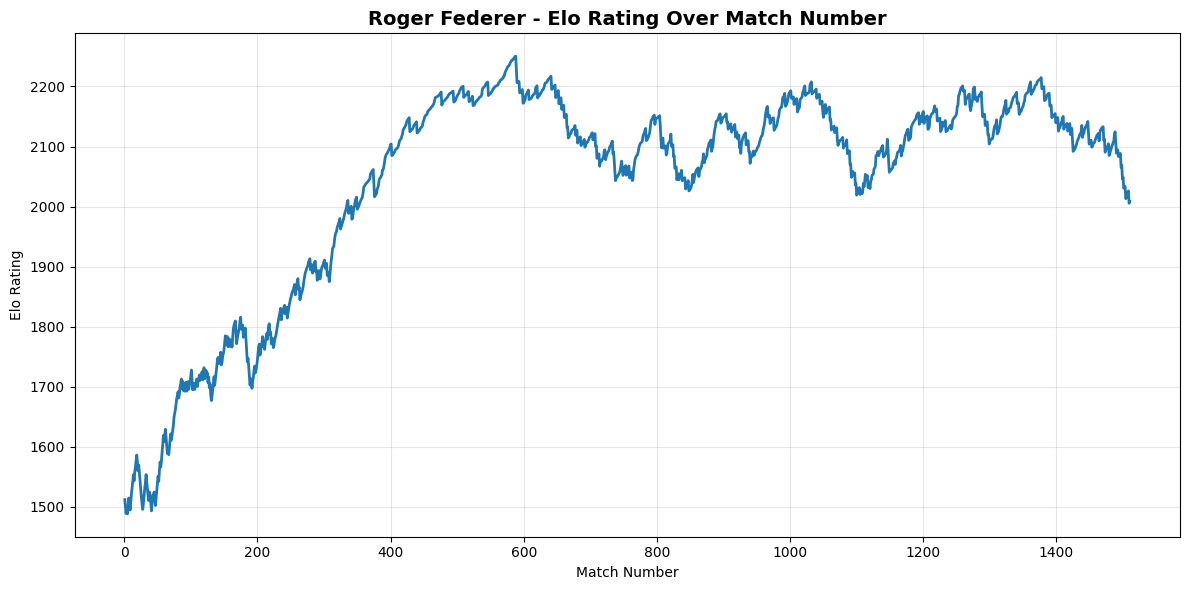

Total matches: 1510
Peak Elo: 2250
Current Elo: 2009


In [30]:
""" Plot Elo rating history for any player by match number """

import matplotlib.pyplot as plt

def plot_player_elo(player_name):
    """Plot Elo rating history for a given player by match number"""
    
    # Filter for player's matches
    player_matches = df_with_elo[
        (df_with_elo['player_A_name'] == player_name) | 
        (df_with_elo['player_B_name'] == player_name)
    ].copy()
    
    if len(player_matches) == 0:
        print(f"No matches found for {player_name}")
        return
    
    # Get Elo rating after each match
    elo_history = []
    for idx, row in player_matches.iterrows():
        if row['player_A_name'] == player_name:
            elo_history.append(row['elo_A_post'])
        else:
            elo_history.append(row['elo_B_post'])
    
    match_numbers = range(1, len(elo_history) + 1)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(match_numbers, elo_history, linewidth=2)
    plt.title(f'{player_name} - Elo Rating Over Match Number', fontsize=14, fontweight='bold')
    plt.xlabel('Match Number')
    plt.ylabel('Elo Rating')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total matches: {len(elo_history)}")
    print(f"Peak Elo: {max(elo_history):.0f}")
    print(f"Current Elo: {elo_history[-1]:.0f}")

# Example usage
plot_player_elo('Roger Federer')

In [31]:
""" Surface-specific Elo Rating System """

def add_surface_elo_columns(df: pd.DataFrame, k: float, init_rating: float) -> pd.DataFrame:
    """Calculate surface-specific Elo ratings for each surface"""
    df = df.copy()
    
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date"]).reset_index(drop=True)
    
    # Separate ratings for each surface
    ratings = {
        'Hard': {},
        'Clay': {},
        'Grass': {}
    }
    
    # Pre-match and post-match rating columns for each surface
    surface_columns = {}
    for surface in ['Hard', 'Clay', 'Grass']:
        surface_columns[surface] = {
            'A_pre': [],
            'B_pre': [],
            'A_post': [],
            'B_post': []
        }
    
    for _, row in df.iterrows():
        a = row["player_A_name"]
        b = row["player_B_name"]
        w = row["winner_name"]
        surface = row["surface"]
        
        # Skip if surface not in our tracked surfaces
        if surface not in ratings:
            for s in ratings:
                surface_columns[s]['A_pre'].append(None)
                surface_columns[s]['B_pre'].append(None)
                surface_columns[s]['A_post'].append(None)
                surface_columns[s]['B_post'].append(None)
            continue
        
        # Get pre-match ratings
        ra = ratings[surface].get(a, init_rating)
        rb = ratings[surface].get(b, init_rating)
        
        # Determine result from A's perspective
        if w == a:
            sa = 1.0
        elif w == b:
            sa = 0.0
        else:
            sa = None
        
        if sa is None:
            # Skip update for bad rows
            for s in ratings:
                if s == surface:
                    surface_columns[s]['A_pre'].append(ra)
                    surface_columns[s]['B_pre'].append(rb)
                    surface_columns[s]['A_post'].append(ra)
                    surface_columns[s]['B_post'].append(rb)
                else:
                    surface_columns[s]['A_pre'].append(None)
                    surface_columns[s]['B_pre'].append(None)
                    surface_columns[s]['A_post'].append(None)
                    surface_columns[s]['B_post'].append(None)
            continue
        
        # Calculate expected scores
        ea = elo_expected(ra, rb)
        eb = 1.0 - ea
        sb = 1.0 - sa
        
        # Update ratings
        ra_new = ra + k * (sa - ea)
        rb_new = rb + k * (sb - eb)
        
        ratings[surface][a] = ra_new
        ratings[surface][b] = rb_new
        
        # Record for this surface
        surface_columns[surface]['A_pre'].append(ra)
        surface_columns[surface]['B_pre'].append(rb)
        surface_columns[surface]['A_post'].append(ra_new)
        surface_columns[surface]['B_post'].append(rb_new)
        
        # Record None for other surfaces
        for s in ratings:
            if s != surface:
                surface_columns[s]['A_pre'].append(None)
                surface_columns[s]['B_pre'].append(None)
                surface_columns[s]['A_post'].append(None)
                surface_columns[s]['B_post'].append(None)
    
    # Add columns to dataframe
    for surface in ['Hard', 'Clay', 'Grass']:
        df[f"elo_A_pre_{surface}"] = surface_columns[surface]['A_pre']
        df[f"elo_B_pre_{surface}"] = surface_columns[surface]['B_pre']
        df[f"elo_A_post_{surface}"] = surface_columns[surface]['A_post']
        df[f"elo_B_post_{surface}"] = surface_columns[surface]['B_post']
    
    return df, ratings

# Calculate surface-specific Elo ratings
df_with_surface_elo, final_surface_ratings = add_surface_elo_columns(df_with_elo, k=24, init_rating=1500)
print(df_with_surface_elo.head())

df_with_surface_elo.to_csv("../data/processed/atp_matches_2000-2024.csv", index=False)

        date tournament_name surface round  best_of    player_A_name  \
0 2000-01-03        Adelaide    Hard    SF        3   Lleyton Hewitt   
1 2000-01-03         Chennai    Hard   R32        3   Jerome Golmard   
2 2000-01-03         Chennai    Hard   R32        3  Fredrik Jonsson   
3 2000-01-03         Chennai    Hard   R32        3    Lorenzo Manta   
4 2000-01-03         Chennai    Hard   R32        3     Leander Paes   

    player_B_name      winner_name        score  player_A_rank  ...  \
0  Nicolas Escude   Lleyton Hewitt  3-6 6-1 6-4           25.0  ...   
1   Martin Spottl   Jerome Golmard      6-3 6-4           35.0  ...   
2     Jan Kroslak  Fredrik Jonsson      6-3 6-3          126.0  ...   
3       Tomas Zib    Lorenzo Manta      7-5 6-2          115.0  ...   
4  Julien Boutter     Leander Paes   6-4 7-6(6)          142.0  ...   

   elo_A_post_Hard  elo_B_post_Hard  elo_A_pre_Clay  elo_B_pre_Clay  \
0           1512.0           1488.0             NaN             NaN  

In [32]:
""" View top 10 players by surface-specific Elo rating """

for surface in ['Hard', 'Clay', 'Grass']:
    surface_ratings = pd.DataFrame([
        {'player': player, 'elo': rating}
        for player, rating in final_surface_ratings[surface].items()
    ]).sort_values('elo', ascending=False)
    
    print(f"\n{'='*50}")
    print(f"Top 10 players on {surface}:")
    print(surface_ratings.head(10).to_string(index=False))


Top 10 players on Hard:
               player         elo
        Jannik Sinner 2140.403213
       Novak Djokovic 2077.457559
        Roger Federer 2043.102097
Juan Martin del Potro 1961.925108
       Carlos Alcaraz 1926.214470
      Robin Soderling 1915.461055
     Alexander Zverev 1906.704076
      Daniil Medvedev 1899.429314
         Rafael Nadal 1871.784537
         Taylor Fritz 1863.818879

Top 10 players on Clay:
            player         elo
      Rafael Nadal 2010.548975
    Novak Djokovic 1995.746659
    Carlos Alcaraz 1914.958081
Stefanos Tsitsipas 1892.458216
     Roger Federer 1886.798773
  Alexander Zverev 1886.411006
   Robin Soderling 1875.834772
       Casper Ruud 1859.322893
 Matteo Berrettini 1834.592452
       Andy Murray 1829.978241

Top 10 players on Grass:
               player         elo
       Novak Djokovic 1962.285796
        Roger Federer 1925.311414
         Rafael Nadal 1794.596981
         Andy Roddick 1772.208742
          Marin Cilic 1767.965336
     

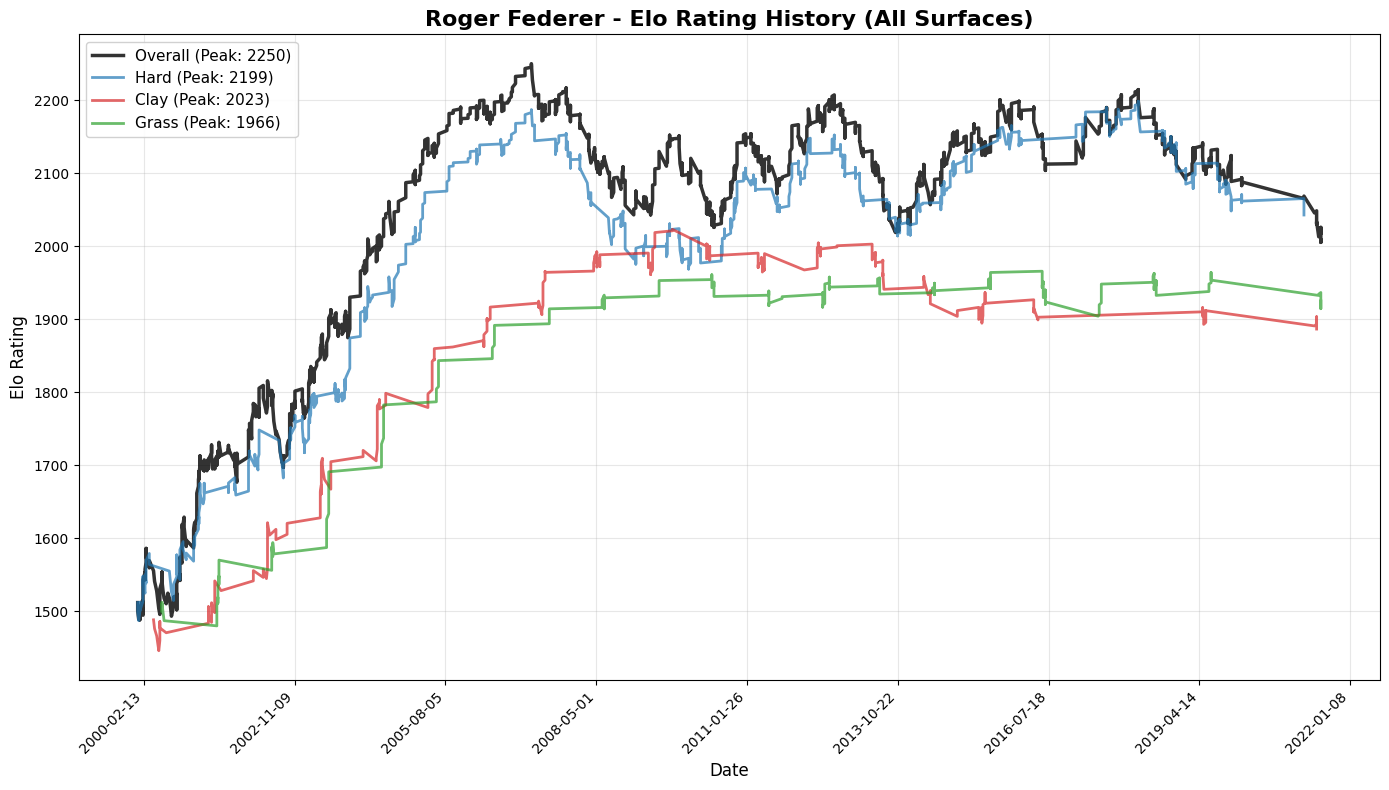

In [33]:
""" Plot all Elo ratings on a single graph """

import matplotlib.pyplot as plt

def plot_all_elos(player_name):
    """
    Plot overall Elo and surface-specific Elo ratings for a given player on one graph
    
    Args:
        player_name: Name of the player to plot
    """
    
    plt.figure(figsize=(14, 8))
    
    # Plot Overall Elo
    player_matches = df_with_elo[
        (df_with_elo['player_A_name'] == player_name) | 
        (df_with_elo['player_B_name'] == player_name)
    ].copy()
    
    if len(player_matches) > 0:
        elo_history = []
        for idx, row in player_matches.iterrows():
            if row['player_A_name'] == player_name:
                elo_history.append({'date': row['date'], 'elo': row['elo_A_post']})
            else:
                elo_history.append({'date': row['date'], 'elo': row['elo_B_post']})
        
        overall_df = pd.DataFrame(elo_history)
        plt.plot(overall_df['date'], overall_df['elo'], linewidth=2.5, color='black', 
                label=f"Overall (Peak: {overall_df['elo'].max():.0f})", alpha=0.8)
    
    # Plot Surface-specific Elos
    surfaces = ['Hard', 'Clay', 'Grass']
    colors = ['#1f77b4', '#d62728', '#2ca02c']  # Blue, Red, Green
    
    for surface, color in zip(surfaces, colors):
        surface_matches = df_with_surface_elo[
            ((df_with_surface_elo['player_A_name'] == player_name) | 
             (df_with_surface_elo['player_B_name'] == player_name)) &
            (df_with_surface_elo['surface'] == surface)
        ].copy()
        
        if len(surface_matches) > 0:
            elo_history = []
            for idx, row in surface_matches.iterrows():
                if row['player_A_name'] == player_name:
                    elo_history.append({'date': row['date'], 'elo': row[f'elo_A_post_{surface}']})
                else:
                    elo_history.append({'date': row['date'], 'elo': row[f'elo_B_post_{surface}']})
            
            surface_df = pd.DataFrame(elo_history)
            # Filter out None values
            surface_df = surface_df[surface_df['elo'].notna()]
            
            if len(surface_df) > 0:
                plt.plot(surface_df['date'], surface_df['elo'], linewidth=2, color=color,
                        label=f"{surface} (Peak: {surface_df['elo'].max():.0f})", alpha=0.7)
    
    plt.title(f'{player_name} - Elo Rating History (All Surfaces)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Elo Rating', fontsize=12)
    plt.legend(loc='best', fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    # Reduce x-axis clutter
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show ~10 date labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_elos('Roger Federer')

In [34]:
""" Create a CSV with all player Elo ratings """

# Combine all players from overall and surface-specific ratings
all_players = set()
all_players.update(final_ratings.keys())
for surface in ['Hard', 'Clay', 'Grass']:
    all_players.update(final_surface_ratings[surface].keys())

# Build the ratings table
ratings_data = []

for player in sorted(all_players):
    ratings_data.append({
        'player': player,
        'elo_overall': final_ratings.get(player, 1500),
        'elo_hard': final_surface_ratings['Hard'].get(player, 1500),
        'elo_clay': final_surface_ratings['Clay'].get(player, 1500),
        'elo_grass': final_surface_ratings['Grass'].get(player, 1500)
    })

df_ratings = pd.DataFrame(ratings_data)

# Sort by overall Elo
df_ratings = df_ratings.sort_values('elo_overall', ascending=False).reset_index(drop=True)

print("\nTop 10 players:")
print(df_ratings.head(10))

# Save ratings to CSV
output_path = '../data/processed/player_elo_ratings.csv'
df_ratings.to_csv(output_path, index=False)
print(f"\nSaved to {output_path}")


Top 10 players:
                  player  elo_overall     elo_hard     elo_clay    elo_grass
0          Jannik Sinner  2158.506755  2140.403213  1784.415018  1663.669779
1         Novak Djokovic  2078.682453  2077.457559  1995.746659  1962.285796
2         Carlos Alcaraz  2012.906547  1926.214470  1914.958081  1736.289027
3          Roger Federer  2008.705394  2043.102097  1886.798773  1925.311414
4        Robin Soderling  1990.947931  1915.461055  1875.834772  1633.091915
5       Alexander Zverev  1955.651974  1906.704076  1886.411006  1660.514963
6  Juan Martin del Potro  1924.114710  1961.925108  1800.038638  1703.024570
7           Taylor Fritz  1911.783287  1863.818879  1713.910818  1640.506869
8        Daniil Medvedev  1900.030867  1899.429314  1689.277310  1697.847833
9           Nick Kyrgios  1896.454915  1848.780604  1642.680341  1677.606825

Saved to ../data/processed/player_elo_ratings.csv
